# Distinguishing Traffic Signs

## Preparing image data

In [0]:
import numpy as np
import zipfile
import pprint

from skimage.transform import resize
from skimage.io import imread

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [0]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import (Flatten, Dense, Dropout)

In [0]:
import urllib.request
import os.path
if not os.path.exists("GTSRB_Final_Training_Images.zip"):
    url = ("https://sid.erda.dk/public/archives/"
    + "daaeac0d7ce1152aea9b61d9f1e19370/"
    + "GTSRB_Final_Training_Images.zip")
    filename = "./GTSRB_Final_Training_Images.zip"
    urllib.request.urlretrieve(url, filename)

In [0]:
IMG_SIZE = 32
TEST_SIZE = 0.2

In [0]:
X, Xt, y, yt = list(), list(), list(), list()

archive = zipfile.ZipFile(
          'GTSRB_Final_Training_Images.zip', 'r')
file_paths = [file for file in archive.namelist() 
              if '.ppm' in file]

for filename in file_paths:
    img = imread(archive.open(filename))
    img = resize(img, 
                 output_shape=(IMG_SIZE, IMG_SIZE),
                 mode='reflect')
    img_class = int(filename.split('/')[-2])
    
    if (hash(filename) % 1000) / 1000 > TEST_SIZE:
        X.append(img)
        y.append(img_class)
    else:
        Xt.append(img)
        yt.append(img_class)

archive.close()

In [9]:
test_ratio = len(Xt) / len(file_paths)
print("Train size:{} test size:{} ({:0.3f})".format(len(X), 
                len(Xt), 
                test_ratio))

Train size:31441 test size:7768 (0.198)


No classes:43


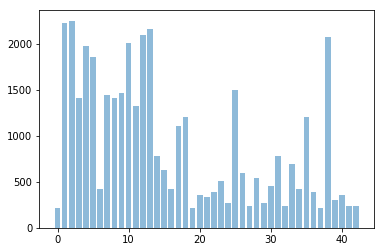

In [10]:
classes, dist = np.unique(y+yt, return_counts=True)
NUM_CLASSES = len(classes)
print ("No classes:{}".format(NUM_CLASSES))

plt.bar(classes, dist, align='center', alpha=0.5)
plt.show()

In [0]:
class_weight = {c:dist[c]/np.sum(dist) for c in classes}

## Running a classification task

In [0]:
batch_size = 256
tgen=ImageDataGenerator(rescale=1./255,
                        rotation_range=5,
                        width_shift_range=0.10, 
                        height_shift_range=0.10)

train_gen = tgen.flow(np.array(X), 
                      to_categorical(y), 
                      batch_size=batch_size)

In [0]:
vgen=ImageDataGenerator(rescale=1./255)

val_gen = vgen.flow(np.array(Xt), 
                    to_categorical(yt), 
                    batch_size=batch_size)

In [14]:
def small_cnn():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same',
                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                     activation='relu'))
    model.add(Conv2D(64, (5, 5), activation='relu'))   
    model.add(Flatten())
    model.add(Dense(768, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model


model = small_cnn()
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=len(X) // batch_size,
                              validation_data=val_gen,
                              validation_steps=len(Xt) // batch_size,
                              class_weight=class_weight,
                              epochs=100, 
                              verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 20s - loss: 0.1125 - acc: 0.0670 - val_loss: 3.4757 - val_acc: 0.1281
Epoch 2/100
 - 13s - loss: 0.1016 - acc: 0.1319 - val_loss: 3.0283 - val_acc: 0.2130
Epoch 3/100
 - 14s - loss: 0.0896 - acc: 0.2102 - val_loss: 2.4584 - val_acc: 0.3496
Epoch 4/100
 - 13s - loss: 0.0744 - acc: 0.3131 - val_loss: 1.7197 - val_acc: 0.5039
Epoch 5/100
 - 14s - loss: 0.0597 - acc: 0.4097 - val_loss: 1.3923 - val_acc: 0.5759
Epoch 6/100
 - 14s - loss: 0.0513 - acc: 0.4743 - val_loss: 1.1201 - val_acc: 0.6500
Epoch 7/100
 - 15s - loss: 0.0444 - acc: 0.5303 - val_loss: 0.9611 - val_acc: 0.7081
Epoch 8/100
 - 14s - loss: 0.0396 - acc: 0.5747 - val_loss: 0.8034 - val_acc: 0.7617
Epoch 9/100
 - 14s - loss: 0.0349 - acc: 0.6166 - val_loss: 0.6925 - val_acc: 0.7853
Epoch 10/100
 - 13s - loss: 0.0315 - acc: 0.6506 - val_loss: 0.6172 - val_acc: 0.8110
Epoch 11/100
 - 14s - loss: 0.0284 - acc: 0.6816 - val_loss: 0.5677 - val_acc: 0.8263
Epoch 12/100
 -

In [16]:
print("Best validation accuracy: {:0.3f}"
       .format(np.max(history.history['val_acc'])))

Best validation accuracy: 0.992


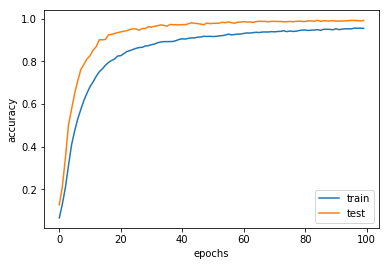

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy'); plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()